# GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Jan 26 03:28:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CFG

In [2]:
CONFIG_NAME = 'config23.yml'

from requests import get
filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
TITLE = filename.split('.')[0]

In [3]:
! rm -r cassava

rm: cannot remove 'cassava': No such file or directory


In [4]:
! git clone https://github.com/raijin0704/cassava.git
# ====================================================
# CFG
# ====================================================
import yaml

CONFIG_PATH = f'./cassava/config/{CONFIG_NAME}'
with open(CONFIG_PATH) as f:
    config = yaml.load(f)

INFO = config['info']
TAG = config['tag']
CFG = config['cfg']

CFG['train'] = True
CFG['inference'] = False

# CFG['debug'] = True

if CFG['debug']:
    CFG['epochs'] = 1


assert INFO['TITLE'] == TITLE, f'{TITLE}, {INFO["TITLE"]}'

Cloning into 'cassava'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 176 (delta 123), reused 10 (delta 5), pack-reused 0
Receiving objects: 100% (176/176), 30.67 KiB | 10.22 MiB/s, done.
Resolving deltas: 100% (123/123), done.


# colab & kaggle notebookでの環境面の処理

## colab

In [5]:
def _colab_kaggle_authority():
    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)


def _install_apex():
    import os
    import subprocess
    import sys
    # import time
    subprocess.run('git clone https://github.com/NVIDIA/apex'.split(' '))
    # time.sleep(10)
    os.chdir('apex')
    subprocess.run('pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .'.split(' '))
    os.chdir('..')


def process_colab():
    import subprocess
    
    # ドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Cloudの権限設定
    from google.colab import auth
    auth.authenticate_user()

    # kaggle設定
    # _colab_kaggle_authority()
    # subprocess.run('pip install --upgrade --force-reinstall --no-deps kaggle'.split(' '))

    # ライブラリ関係
    subprocess.run('pip install --upgrade opencv-python'.split(' '))
    subprocess.run('pip install --upgrade albumentations'.split(' '))
    subprocess.run('pip install timm'.split(' '))
    # if CFG['apex']:
    #     print('installing apex')
    #     _install_apex()
    #     print('done')

    # 各種pathの設定
    # DATA_PATH = '/content/drive/Shareddrives/便利用/kaggle/cassava/input/'
    DATA_PATH = '/content/input'
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = f'/content/drive/Shareddrives/便利用/kaggle/cassava/notebook/{TITLE}.ipynb'

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## kaggle notebook

In [6]:
def _kaggle_gcp_authority():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

def process_kaggle():
    # GCP設定
    _kaggle_gcp_authority()

    # 各種pathの設定
    DATA_PATH = '../input/cassava-leaf-disease-classification/'
    ! mkdir output
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = './__notebook__.ipynb'
    # system path
    import sys
    sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## 共通

In [7]:
def process_common():
    # ライブラリ関係
    import subprocess
    subprocess.run('pip install mlflow'.split(' '))

    # 環境変数
    import os
    os.environ["GCLOUD_PROJECT"] = INFO['PROJECT_ID']

In [8]:
try:
    from google.colab import auth
except ImportError:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_kaggle()
    env = 'kaggle'
else:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_colab()
    env = 'colab'
finally:
    process_common()

Mounted at /content/drive


In [9]:
!rm -r /content/input

rm: cannot remove '/content/input': No such file or directory


In [10]:
import os

if env=='colab':
    ! cp /content/drive/Shareddrives/便利用/kaggle/cassava/input.zip /content/input.zip
    ! unzip input.zip
    ! rm input.zip
train_num = len(os.listdir(DATA_PATH+"/train_images"))
assert train_num == 21397

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: input/train_images/1137739472.jpg  
  inflating: input/train_images/441313044.jpg  
  inflating: input/train_images/982733151.jpg  
  inflating: input/train_images/3643480526.jpg  
  inflating: input/train_images/2440664696.jpg  
  inflating: input/train_images/370523815.jpg  
  inflating: input/train_images/1125560878.jpg  
  inflating: input/train_images/3303165486.jpg  
  inflating: input/train_images/510873412.jpg  
  inflating: input/train_images/550429661.jpg  
  inflating: input/train_images/1127352598.jpg  
  inflating: input/train_images/3767196717.jpg  
  inflating: input/train_images/25671501.jpg  
  inflating: input/train_images/2296550892.jpg  
  inflating: input/train_images/754482252.jpg  
  inflating: input/train_images/3714169299.jpg  
  inflating: input/train_images/127776052.jpg  
  inflating: input/train_images/3761357668.jpg  
  inflating: input/train_images/996534381.jpg  
  inflating: input/train_images/255701322.jpg  

# install apex

In [11]:
if CFG['apex']:
    try:
        import apex
    except Exception:
        ! git clone https://github.com/NVIDIA/apex.git
        % cd apex
        !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
        %cd ..

# Library

In [12]:
# ====================================================
# Library
# ====================================================
import os
import datetime
import math
import time
import random
import glob
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, CenterCrop
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import mlflow

import warnings 
warnings.filterwarnings('ignore')

if CFG['apex']:
    from apex import amp

if CFG['debug']:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda')
start_time = datetime.datetime.now()
start_time_str = start_time.strftime('%m%d%H%M')

# Directory settings

In [13]:
# ====================================================
# Directory settings
# ====================================================
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# save basic files

In [14]:
# with open(f'{OUTPUT_DIR}/{start_time_str}_TAG.json', 'w') as f:
#     json.dump(TAG, f, indent=4)
    
# with open(f'{OUTPUT_DIR}/{start_time_str}_CFG.json', 'w') as f:
#     json.dump(CFG, f, indent=4)

import shutil
notebook_path = f'{OUTPUT_DIR}/{start_time_str}_{TITLE}.ipynb'
shutil.copy2(NOTEBOOK_PATH, notebook_path)

'./output//01260332_23t-efficientnet_b4-cutmix-tta-batch512.ipynb'

# Data Loading

In [15]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
label_map = pd.read_json(f'{DATA_PATH}/label_num_to_disease_map.json', 
                         orient='index')

if CFG['debug']:
    train = train.sample(n=1000, random_state=CFG['seed']).reset_index(drop=True)

# Utils

In [16]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, FileHandler,  Formatter,  StreamHandler
    from logging import INFO as INFO_
    logger = getLogger(__name__)
    logger.setLevel(INFO_)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger_path = OUTPUT_DIR+f'{start_time_str}_train.log'
LOGGER = init_logger(logger_path)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG['seed'])


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, save_path='checkpoint.pt',
                 counter=0, best_score=None, save_latest_path=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            save_path (str): Directory for saving a model.
                             Default: "'checkpoint.pt'"
        """
        self.patience = patience
        self.verbose = verbose
        self.save_path = save_path
        self.counter = counter
        self.best_score = best_score
        self.save_latest_path = save_latest_path
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, preds, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.save_latest(val_loss, model, preds, epoch, score)
        elif score >= self.best_score:
            self.counter = 0
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.save_latest(val_loss, model, preds, epoch, score)
        # nanになったら学習ストップ
        elif math.isnan(score):
            self.early_stop = True
        else:
            self.counter += 1
            if self.save_latest_path is not None:
                self.save_latest(val_loss, model, preds, epoch, score)
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, preds, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.10f} --> {val_loss:.10f}).  Saving model ...')
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'best_score' : self.best_score, 'counter' : self.counter},
                   self.save_path)
        self.val_loss_min = val_loss

    def save_latest(self, val_loss, model, preds, epoch, score):
        '''Saves latest model.'''
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'score' : score, 'counter' : self.counter},
                   self.save_latest_path)
        self.val_loss_min = val_loss

In [17]:
def remove_glob(pathname, recursive=True):
    for p in glob.glob(pathname, recursive=recursive):
        if os.path.isfile(p):
            os.remove(p)


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# CV split

In [18]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG['n_fold'], shuffle=True, random_state=CFG['seed'])
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG['target_col']])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG['target_col']]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [19]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/test_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [20]:
# train_dataset = TrainDataset(train, transform=None)

# for i in range(1):
#     image, label = train_dataset[i]
#     plt.imshow(image)
#     plt.title(f'label: {label}')
#     plt.show() 

# Transforms

In [21]:
def _get_train_augmentations(aug_list):
    process = []
    for aug in aug_list:
        if aug ==  'Resize':
            process.append(Resize(CFG['size'], CFG['size']))
        elif aug == 'RandomResizedCrop':
            process.append(RandomResizedCrop(CFG['size'], CFG['size']))
        elif aug =='CenterCrop':
            process.append(CenterCrop(CFG['size'], CFG['size']))
        elif aug == 'Transpose':
            process.append(Transpose(p=0.5))
        elif aug == 'HorizontalFlip':
            process.append(HorizontalFlip(p=0.5))
        elif aug == 'VerticalFlip':
            process.append(VerticalFlip(p=0.5))
        elif aug == 'ShiftScaleRotate':
            process.append(ShiftScaleRotate(p=0.5))
        elif aug == 'Cutout':
            process.append(Cutout(max_h_size=CFG['CutoutSize'], max_w_size=CFG['CutoutSize'], p=0.5))
        elif aug == 'Normalize':
            process.append(Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ))
        elif aug in ['mixup', 'cutmix', 'fmix']:
            pass
        else:
            raise ValueError(f'{aug} is not suitable')

    process.append(ToTensorV2())

    return process



def _get_valid_augmentations(aug_list):
    process = []
    for aug in aug_list:
        if aug ==  'Resize':
            process.append(Resize(CFG['size'], CFG['size']))
        elif aug == 'RandomResizedCrop':
            process.append(OneOf(
                [RandomResizedCrop(CFG['size'], CFG['size'], p=0.5), 
                 Resize(CFG['size'], CFG['size'], p=0.5)], p=1))
        elif aug =='CenterCrop':
            process.append(OneOf(
                [CenterCrop(CFG['size'], CFG['size'], p=0.5), 
                 Resize(CFG['size'], CFG['size'], p=0.5)], p=1))
        elif aug == 'Transpose':
            process.append(Transpose(p=0.5))
        elif aug == 'HorizontalFlip':
            process.append(HorizontalFlip(p=0.5))
        elif aug == 'VerticalFlip':
            process.append(VerticalFlip(p=0.5))
        elif aug == 'ShiftScaleRotate':
            process.append(ShiftScaleRotate(p=0.5))
        elif aug == 'Normalize':
            process.append(Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ))
        elif aug in ['mixup', 'cutmix', 'fmix']:
            pass
        else:
            raise ValueError(f'{aug} is not suitable')

    process.append(ToTensorV2())

    return process

In [22]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose(
            _get_train_augmentations(TAG['augmentation'])
        )

    elif data == 'valid':
        try:
            augmentations = TAG['valid_augmentation']
        except KeyError:
             augmentations = ['Resize', 'Normalize']
        return Compose(
            _get_valid_augmentations(augmentations)
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

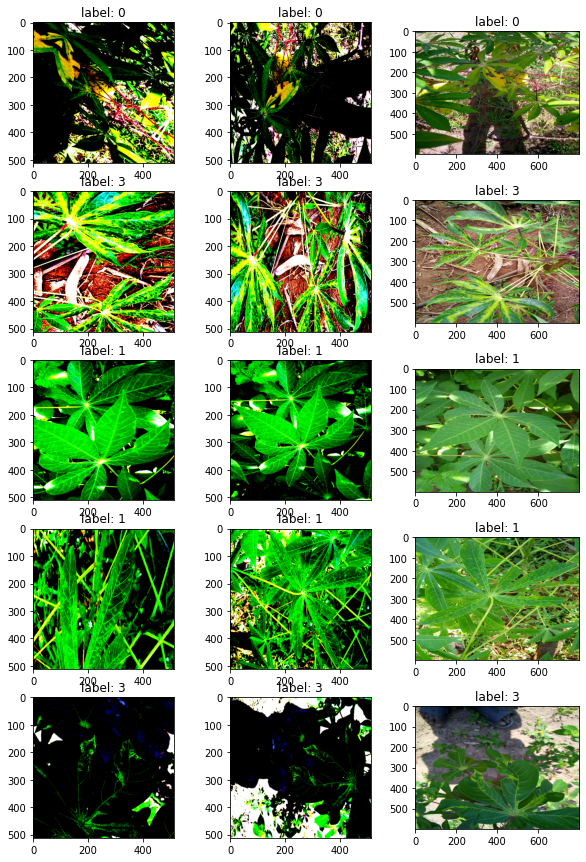

In [23]:
num_fig = 5

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
valid_dataset = TrainDataset(train, transform=get_transforms(data='valid'))
origin_dataset = TrainDataset(train, transform=None)

fig, ax = plt.subplots(num_fig, 3, figsize=(10, num_fig*3))

for j, dataset in enumerate([train_dataset, valid_dataset, origin_dataset]):
    for i in range(num_fig):
        image, label = dataset[i]
        if j < 2:
            ax[i,j].imshow(image.transpose(0,2).transpose(0,1))
        else:
            ax[i,j].imshow(image)
        ax[i,j].set_title(f'label: {label}') 

# Bi-tempered logistic loss

In [24]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

# MODEL

In [25]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.model, 'classifier'):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG['target_size'])
        elif hasattr(self.model, 'fc'):
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG['target_size'])

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
model = CustomModel(model_name=TAG['model_name'], pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0580, -0.0301, -0.0442, -0.0052,  0.0200],
        [-0.7939,  0.2998,  0.3610, -0.0214, -0.2829],
        [ 0.0389,  0.0104,  0.0070, -0.0092,  0.0260],
        [ 0.0650, -0.0144, -0.0336, -0.0112,  0.0293]],
       grad_fn=<AddmmBackward>)


# Helper functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))




In [28]:
# ====================================================
# loss
# ====================================================
def get_loss(criterion, y_preds, labels):
    if TAG['criterion']=='CrossEntropyLoss':
        loss = criterion(y_preds, labels)
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        loss = criterion(y_preds, labels, t1=CFG['bi_tempered_loss_t1'], t2=CFG['bi_tempered_loss_t2'])
    return loss

In [29]:
# ====================================================
# Helper functions
# ====================================================
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        r = np.random.rand(1)
        is_aug = r < 0.5    # probability of augmentation
        if is_aug & ('cutmix' in TAG['augmentation']) & (epoch+1>=CFG['heavy_aug_start_epoch']):
            # generate mixed sample
            # inference from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
            lam = np.random.beta(CFG['CutmixAlpha'], CFG['CutmixAlpha'])
            rand_index = torch.randperm(images.size()[0]).to(device)
            labels_a = labels
            labels_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
            # compute output
            y_preds = model(images)
            loss = get_loss(criterion, y_preds, labels_a) * lam + \
                    get_loss(criterion, y_preds, labels_b) * (1. - lam)
        else:
            y_preds = model(images)
            loss = get_loss(criterion, y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        if CFG['apex']:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        # clear memory
        del loss, y_preds
        torch.cuda.empty_cache()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG['max_grad_norm'])
        if (step + 1) % CFG['gradient_accumulation_steps'] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            # model.load_state_dict(state['model'])
            model.load_state_dict(state)
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [30]:
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if TAG['scheduler']=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG['factor'], patience=CFG['patience'], verbose=True, eps=CFG['eps'])
    elif TAG['scheduler']=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG['T_max'], eta_min=CFG['min_lr'], last_epoch=-1)
    elif TAG['scheduler']=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    return scheduler

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if TAG['criterion']=='CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        criterion = bi_tempered_logistic_loss
    return criterion

In [31]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    if not CFG['debug']:
        mlflow.set_tag('running.fold', str(fold))
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=True, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=False, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & criterion
    # ====================================================
    best_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'
    latest_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_latest.pth'

    model = CustomModel(TAG['model_name'], pretrained=True)
    model.to(device)
    # 学習途中の重みがあれば読み込み
    if os.path.isfile(latest_model_path):
        state_latest = torch.load(latest_model_path)
        state_best = torch.load(best_model_path)
        model.load_state_dict(state_latest['model'])
        epoch_start = state_latest['epoch']+1
        # er_best_score = state_latest['score']
        er_counter = state_latest['counter']
        er_best_score = state_best['best_score']

        LOGGER.info(f'Load training model in epoch:{epoch_start}, best_score:{er_best_score:.3f}, counter:{er_counter}')

    # 学習済みモデルを再学習する場合
    elif os.path.isfile(best_model_path):
        state_best = torch.load(best_model_path)
        model.load_state_dict(state_best['model'])
        epoch_start = 0 # epochは0からカウントしなおす
        er_counter = 0
        er_best_score = state_best['best_score']

        LOGGER.info(f'Retrain model, best_score:{er_best_score:.3f}')
    else:
        epoch_start = 0
        er_best_score = None
        er_counter = 0

    optimizer = Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    # 再開時のepochまでschedulerを進める
    for _ in range(epoch_start):
        if isinstance(scheduler, ReduceLROnPlateau):
            # TODO avg_val_lossを履歴から取得する
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

    # ====================================================
    # apex
    # ====================================================
    if CFG['apex']:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    # best_score = 0.
    # best_loss = np.inf
    early_stopping = EarlyStopping(
                            patience=CFG['early_stopping_round'], 
                            verbose=True,
                            save_path=best_model_path,
                            counter=er_counter, best_score=er_best_score, 
                            save_latest_path=latest_model_path)
    
    for epoch in range(epoch_start, CFG['epochs']):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG['target_col']].values
        
        # early stopping
        early_stopping(avg_val_loss, model, preds, epoch)
        if early_stopping.early_stop:
            print(f'Epoch {epoch+1} - early stopping')
            break
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric(f"fold{fold} avg_train_loss", avg_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} avg_valid_loss", avg_val_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} score", score, step=epoch)
            mlflow.log_metric(f"fold{fold} lr", scheduler.get_last_lr()[0], step=epoch)
            mlflow.log_artifact(best_model_path)
            if os.path.isfile(latest_model_path):
                mlflow.log_artifact(latest_model_path)
    
    check_point = torch.load(best_model_path)
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [32]:
def get_trained_fold_preds(folds, fold, best_model_path):
    val_idx = folds[folds['fold'] == fold].index
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    check_point = torch.load(best_model_path)
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds


def save_confusion_matrix(oof):
    from sklearn.metrics import confusion_matrix
    cm_ = confusion_matrix(oof['label'], oof['preds'], labels=[0,1,2,3,4])
    label_name = ['0 (CBB)', '1 (CBSD)', '2 (CGM)', '3 (CMD)', '4 (Healthy)']
    cm = pd.DataFrame(cm_, index=label_name, columns=label_name)
    cm.to_csv(OUTPUT_DIR+'oof_confusion_matrix.csv', index=True)

In [33]:
# ====================================================
# main
# ====================================================
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG['target_col']].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.5f}')
    
    return score

    

def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """
    
    if CFG['train']:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG['n_fold']):
            best_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'
            if fold in CFG['trn_fold']:
                _oof_df = train_loop(folds, fold)
            elif os.path.exists(best_model_path):
                _oof_df = get_trained_fold_preds(folds, fold, best_model_path)
            else:
                _oof_df = None
            if _oof_df is not None:
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                _ = get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        score = get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        save_confusion_matrix(oof_df)
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric('oof score', score)
            mlflow.delete_tag('running.fold')
            mlflow.log_artifact(OUTPUT_DIR+'oof_df.csv')
    
    if CFG['inference']:
        # inference
        model = CustomModel(TAG['model_name'], pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth') for fold in CFG['trn_fold']]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'], shuffle=False, 
                                 num_workers=CFG['num_workers'], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

# rerun

In [34]:
def _load_save_point(run_id):
    # どこで中断したか取得
    stop_fold = int(mlflow.get_run(run_id=run_id).to_dictionary()['data']['tags']['running.fold'])
    # 学習対象のfoldを変更
    CFG['trn_fold'] = [fold for fold in CFG['trn_fold'] if fold>=stop_fold]
    # 学習済みモデルがあれば.pthファイルを取得(学習中も含む)
    client = mlflow.tracking.MlflowClient()
    artifacts = [artifact for artifact in client.list_artifacts(run_id) if ".pth" in artifact.path]
    for artifact in artifacts:
        client.download_artifacts(run_id, artifact.path, OUTPUT_DIR)


def check_have_run():
    results = mlflow.search_runs(INFO['EXPERIMENT_ID'])
    run_id_list = results[results['tags.mlflow.runName']==TITLE]['run_id'].tolist()
    # 初めて実行する場合
    if len(run_id_list) == 0:
        run_id = None
    # 既に実行されている場合
    else:
        assert len(run_id_list)==1
        run_id = run_id_list[0]
        _load_save_point(run_id)

    return run_id

In [35]:
if __name__ == '__main__':
    if CFG['debug']:
        main()
    else:
        mlflow.set_tracking_uri(INFO['TRACKING_URI'])
        mlflow.set_experiment('single model')
        # 既に実行済みの場合は続きから実行する
        run_id = check_have_run()
        with mlflow.start_run(run_id=run_id, run_name=TITLE):
            if run_id is None:
                mlflow.log_artifact(CONFIG_PATH)
                mlflow.log_param('device', device)
                mlflow.set_tag('env', env)
                mlflow.set_tags(TAG)
                mlflow.log_params(CFG)
            mlflow.log_artifact(notebook_path)
            main()
            mlflow.log_artifacts(OUTPUT_DIR)
            remove_glob(f'{OUTPUT_DIR}/*latest.pth')
            if env=="kaggle":
                shutil.copy2(CONFIG_PATH, f'{OUTPUT_DIR}/{CONFIG_NAME}')
                ! rm -r cassava
            elif env=="colab":
                shutil.copytree(OUTPUT_DIR, f'{INFO["SHARE_DRIVE_PATH"]}/{TITLE}')
                shutil.copy2(CONFIG_PATH, f'{INFO["SHARE_DRIVE_PATH"]}/{TITLE}/{CONFIG_NAME}')

========== fold: 0 result ==========
Score: 0.89089
========== fold: 1 result ==========
Score: 0.89486
========== fold: 2 result ==========
Score: 0.88432
========== fold: 3 result ==========
Score: 0.88268
========== fold: 4 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
Load training model in epoch:3, best_score:-0.130, counter:0


Epoch: [4][0/2139] Data 1.040 (1.040) Elapsed 0m 2s (remain 80m 24s) Loss: 0.2828(0.2828) Grad: 0.0153  
Epoch: [4][100/2139] Data 0.000 (0.010) Elapsed 1m 15s (remain 25m 30s) Loss: 0.1215(0.2091) Grad: 0.1016  
Epoch: [4][200/2139] Data 0.000 (0.005) Elapsed 2m 31s (remain 24m 16s) Loss: 0.3046(0.1995) Grad: 0.0540  
Epoch: [4][300/2139] Data 0.000 (0.004) Elapsed 3m 47s (remain 23m 9s) Loss: 0.1721(0.2030) Grad: 0.1110  
Epoch: [4][400/2139] Data 0.000 (0.003) Elapsed 5m 4s (remain 22m 0s) Loss: 0.1031(0.2055) Grad: 0.0741  
Epoch: [4][500/2139] Data 0.000 (0.002) Elapsed 6m 21s (remain 20m 48s) Loss: 0.0631(0.2020) Grad: 0.1239  
Epoch: [4][600/2139] Data 0.000 (0.002) Elapsed 7m 39s (remain 19m 35s) Loss: 0.2957(0.2031) Grad: 0.0920  
Epoch: [4][700/2139] Data 0.000 (0.002) Elapsed 8m 56s (remain 18m 20s) Loss: 0.3595(0.2029) Grad: 0.1346  
Epoch: [4][800/2139] Data 0.000 (0.001) Elapsed 10m 14s (remain 17m 5s) Loss: 0.2097(0.2035) Grad: 0.0895  
Epoch: [4][900/2139] Data 0.000 (0

Epoch 4 - avg_train_loss: 0.2008  avg_val_loss: 0.1273  time: 1737s
Epoch 4 - Accuracy: 0.8553400327179248


Epoch: [5][0/2139] Data 0.945 (0.945) Elapsed 0m 1s (remain 68m 35s) Loss: 0.1972(0.1972) Grad: 0.1040  
Epoch: [5][100/2139] Data 0.000 (0.010) Elapsed 1m 19s (remain 26m 47s) Loss: 0.1483(0.1942) Grad: 0.1054  
Epoch: [5][200/2139] Data 0.000 (0.005) Elapsed 2m 37s (remain 25m 17s) Loss: 0.1203(0.1872) Grad: 0.0612  
Epoch: [5][300/2139] Data 0.000 (0.003) Elapsed 3m 55s (remain 23m 55s) Loss: 0.0677(0.1908) Grad: 0.1359  
Epoch: [5][400/2139] Data 0.000 (0.003) Elapsed 5m 12s (remain 22m 35s) Loss: 0.0665(0.1943) Grad: 0.0890  
Epoch: [5][500/2139] Data 0.000 (0.002) Elapsed 6m 30s (remain 21m 17s) Loss: 0.4110(0.1977) Grad: 0.1385  
Epoch: [5][600/2139] Data 0.000 (0.002) Elapsed 7m 48s (remain 19m 58s) Loss: 0.0681(0.1975) Grad: 0.0793  
Epoch: [5][700/2139] Data 0.000 (0.001) Elapsed 9m 5s (remain 18m 39s) Loss: 0.3324(0.2001) Grad: 0.1640  
Epoch: [5][800/2139] Data 0.000 (0.001) Elapsed 10m 23s (remain 17m 21s) Loss: 0.1900(0.1987) Grad: 0.1234  
Epoch: [5][900/2139] Data 0.000

Epoch 5 - avg_train_loss: 0.1945  avg_val_loss: 0.1201  time: 1746s
Epoch 5 - Accuracy: 0.8623510165926619


Epoch: [6][0/2139] Data 0.938 (0.938) Elapsed 0m 2s (remain 72m 26s) Loss: 0.1426(0.1426) Grad: 0.1102  
Epoch: [6][100/2139] Data 0.000 (0.009) Elapsed 1m 19s (remain 26m 47s) Loss: 0.1548(0.1953) Grad: 0.0990  
Epoch: [6][200/2139] Data 0.000 (0.005) Elapsed 2m 37s (remain 25m 16s) Loss: 0.1095(0.1981) Grad: 0.0582  
Epoch: [6][300/2139] Data 0.000 (0.003) Elapsed 3m 54s (remain 23m 54s) Loss: 0.1523(0.1929) Grad: 0.1213  
Epoch: [6][400/2139] Data 0.000 (0.002) Elapsed 5m 12s (remain 22m 35s) Loss: 0.2084(0.1909) Grad: 0.0841  
Epoch: [6][500/2139] Data 0.000 (0.002) Elapsed 6m 30s (remain 21m 16s) Loss: 0.4251(0.1870) Grad: 0.1315  
Epoch: [6][600/2139] Data 0.000 (0.002) Elapsed 7m 47s (remain 19m 57s) Loss: 0.2824(0.1860) Grad: 0.0941  
Epoch: [6][700/2139] Data 0.000 (0.001) Elapsed 9m 5s (remain 18m 39s) Loss: 0.2001(0.1843) Grad: 0.1482  
Epoch: [6][800/2139] Data 0.000 (0.001) Elapsed 10m 23s (remain 17m 20s) Loss: 0.0243(0.1842) Grad: 0.1048  
Epoch: [6][900/2139] Data 0.000

Epoch 6 - avg_train_loss: 0.1864  avg_val_loss: 0.1184  time: 1745s
Epoch 6 - Accuracy: 0.8686609020799252


Epoch: [7][0/2139] Data 0.979 (0.979) Elapsed 0m 1s (remain 68m 55s) Loss: 0.0726(0.0726) Grad: 0.0930  
Epoch: [7][100/2139] Data 0.000 (0.010) Elapsed 1m 19s (remain 26m 48s) Loss: 0.0281(0.1857) Grad: 0.1400  
Epoch: [7][200/2139] Data 0.000 (0.005) Elapsed 2m 37s (remain 25m 16s) Loss: 0.0872(0.1866) Grad: 0.0676  
Epoch: [7][300/2139] Data 0.000 (0.003) Elapsed 3m 54s (remain 23m 54s) Loss: 0.2032(0.1899) Grad: 0.1274  
Epoch: [7][400/2139] Data 0.000 (0.003) Elapsed 5m 12s (remain 22m 34s) Loss: 0.1152(0.1856) Grad: 0.0736  
Epoch: [7][500/2139] Data 0.000 (0.002) Elapsed 6m 30s (remain 21m 15s) Loss: 0.1298(0.1888) Grad: 0.1366  
Epoch: [7][600/2139] Data 0.000 (0.002) Elapsed 7m 47s (remain 19m 57s) Loss: 0.0801(0.1853) Grad: 0.1094  
Epoch: [7][700/2139] Data 0.000 (0.002) Elapsed 9m 5s (remain 18m 39s) Loss: 0.0791(0.1859) Grad: 0.1586  
Epoch: [7][800/2139] Data 0.000 (0.001) Elapsed 10m 23s (remain 17m 21s) Loss: 0.1809(0.1856) Grad: 0.1060  
Epoch: [7][900/2139] Data 0.000

Epoch 7 - avg_train_loss: 0.1856  avg_val_loss: 0.1168  time: 1746s
Epoch 7 - Accuracy: 0.8642206122925917


Epoch: [8][0/2139] Data 0.966 (0.966) Elapsed 0m 1s (remain 69m 28s) Loss: 0.0121(0.0121) Grad: 0.0909  
Epoch: [8][100/2139] Data 0.000 (0.010) Elapsed 1m 19s (remain 26m 48s) Loss: 0.2769(0.1849) Grad: 0.1202  
Epoch: [8][200/2139] Data 0.000 (0.005) Elapsed 2m 37s (remain 25m 18s) Loss: 0.1250(0.1934) Grad: 0.0596  
Epoch: [8][300/2139] Data 0.000 (0.003) Elapsed 3m 55s (remain 23m 57s) Loss: 0.1457(0.1917) Grad: 0.1326  
Epoch: [8][400/2139] Data 0.000 (0.003) Elapsed 5m 13s (remain 22m 37s) Loss: 0.2878(0.1878) Grad: 0.0800  
Epoch: [8][500/2139] Data 0.000 (0.002) Elapsed 6m 30s (remain 21m 17s) Loss: 0.2036(0.1853) Grad: 0.1388  
Epoch: [8][600/2139] Data 0.000 (0.002) Elapsed 7m 48s (remain 19m 59s) Loss: 0.0570(0.1866) Grad: 0.0838  
Epoch: [8][700/2139] Data 0.000 (0.002) Elapsed 9m 6s (remain 18m 41s) Loss: 0.1902(0.1875) Grad: 0.1465  
Epoch: [8][800/2139] Data 0.000 (0.001) Elapsed 10m 24s (remain 17m 23s) Loss: 0.2952(0.1876) Grad: 0.1301  
Epoch: [8][900/2139] Data 0.000

Epoch 8 - avg_train_loss: 0.1834  avg_val_loss: 0.1113  time: 1754s
Epoch 8 - Accuracy: 0.8716989950923113


Epoch: [9][0/2139] Data 0.917 (0.917) Elapsed 0m 1s (remain 69m 1s) Loss: 0.1489(0.1489) Grad: 0.1004  
Epoch: [9][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 54s) Loss: 0.4620(0.2013) Grad: 0.1274  
Epoch: [9][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 24s) Loss: 0.0994(0.1905) Grad: 0.0517  
Epoch: [9][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 2s) Loss: 0.1054(0.1896) Grad: 0.1284  
Epoch: [9][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 42s) Loss: 0.2275(0.1898) Grad: 0.0887  
Epoch: [9][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.1041(0.1886) Grad: 0.1346  
Epoch: [9][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 4s) Loss: 0.1876(0.1865) Grad: 0.0874  
Epoch: [9][700/2139] Data 0.000 (0.001) Elapsed 9m 8s (remain 18m 45s) Loss: 0.2167(0.1842) Grad: 0.1528  
Epoch: [9][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.2836(0.1831) Grad: 0.1089  
Epoch: [9][900/2139] Data 0.000 (0

Epoch 9 - avg_train_loss: 0.1814  avg_val_loss: 0.1131  time: 1755s
Epoch 9 - Accuracy: 0.87146529562982


EarlyStopping counter: 1 out of 5
Epoch: [10][0/2139] Data 0.908 (0.908) Elapsed 0m 1s (remain 63m 20s) Loss: 0.2142(0.2142) Grad: 0.1006  
Epoch: [10][100/2139] Data 0.000 (0.009) Elapsed 1m 19s (remain 26m 52s) Loss: 0.2782(0.1685) Grad: 0.1277  
Epoch: [10][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 23s) Loss: 0.2730(0.1755) Grad: 0.0890  
Epoch: [10][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 2s) Loss: 0.1910(0.1736) Grad: 0.1114  
Epoch: [10][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 42s) Loss: 0.2178(0.1765) Grad: 0.0876  
Epoch: [10][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.0782(0.1815) Grad: 0.1327  
Epoch: [10][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 5s) Loss: 0.0727(0.1799) Grad: 0.1070  
Epoch: [10][700/2139] Data 0.000 (0.001) Elapsed 9m 9s (remain 18m 46s) Loss: 0.1560(0.1834) Grad: 0.1412  
Epoch: [10][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.1037(0.1807) Grad:

Epoch 10 - avg_train_loss: 0.1815  avg_val_loss: 0.1125  time: 1756s
Epoch 10 - Accuracy: 0.8702967983173638


EarlyStopping counter: 2 out of 5
Epoch: [11][0/2139] Data 0.885 (0.885) Elapsed 0m 1s (remain 67m 40s) Loss: 0.0420(0.0420) Grad: 0.0826  
Epoch: [11][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 56s) Loss: 0.0750(0.1694) Grad: 0.1311  
Epoch: [11][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 26s) Loss: 0.0260(0.1709) Grad: 0.0501  
Epoch: [11][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 4s) Loss: 0.1325(0.1661) Grad: 0.1191  
Epoch: [11][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 44s) Loss: 0.1105(0.1723) Grad: 0.0802  
Epoch: [11][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 24s) Loss: 0.0402(0.1750) Grad: 0.1589  
Epoch: [11][600/2139] Data 0.000 (0.002) Elapsed 7m 51s (remain 20m 5s) Loss: 0.2204(0.1786) Grad: 0.1036  
Epoch: [11][700/2139] Data 0.000 (0.001) Elapsed 9m 9s (remain 18m 47s) Loss: 0.2090(0.1787) Grad: 0.1877  
Epoch: [11][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 28s) Loss: 0.2290(0.1771) Grad:

Epoch 11 - avg_train_loss: 0.1781  avg_val_loss: 0.1110  time: 1757s
Epoch 11 - Accuracy: 0.8754381864921711


Epoch: [12][0/2139] Data 0.965 (0.965) Elapsed 0m 1s (remain 70m 43s) Loss: 0.2318(0.2318) Grad: 0.1162  
Epoch: [12][100/2139] Data 0.000 (0.010) Elapsed 1m 20s (remain 26m 58s) Loss: 0.3565(0.1934) Grad: 0.1176  
Epoch: [12][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 26s) Loss: 0.0262(0.1721) Grad: 0.0576  
Epoch: [12][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 3s) Loss: 0.3465(0.1702) Grad: 0.1601  
Epoch: [12][400/2139] Data 0.000 (0.003) Elapsed 5m 14s (remain 22m 43s) Loss: 0.0569(0.1759) Grad: 0.0776  
Epoch: [12][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.3990(0.1769) Grad: 0.1574  
Epoch: [12][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 5s) Loss: 0.2692(0.1787) Grad: 0.1130  
Epoch: [12][700/2139] Data 0.000 (0.002) Elapsed 9m 9s (remain 18m 46s) Loss: 0.3979(0.1790) Grad: 0.1511  
Epoch: [12][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.2555(0.1805) Grad: 0.1344  
Epoch: [12][900/2139] Da

Epoch 12 - avg_train_loss: 0.1772  avg_val_loss: 0.1114  time: 1756s
Epoch 12 - Accuracy: 0.8768403832671184


EarlyStopping counter: 1 out of 5
Epoch: [13][0/2139] Data 0.851 (0.851) Elapsed 0m 1s (remain 68m 2s) Loss: 0.3775(0.3775) Grad: 0.1009  
Epoch: [13][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 56s) Loss: 0.2730(0.1907) Grad: 0.1089  
Epoch: [13][200/2139] Data 0.000 (0.004) Elapsed 2m 38s (remain 25m 25s) Loss: 0.1519(0.1853) Grad: 0.0595  
Epoch: [13][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 2s) Loss: 0.5133(0.1831) Grad: 0.1431  
Epoch: [13][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 42s) Loss: 0.1883(0.1782) Grad: 0.0687  
Epoch: [13][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.0802(0.1746) Grad: 0.1488  
Epoch: [13][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 4s) Loss: 0.2986(0.1748) Grad: 0.1149  
Epoch: [13][700/2139] Data 0.000 (0.001) Elapsed 9m 8s (remain 18m 45s) Loss: 0.1987(0.1740) Grad: 0.1427  
Epoch: [13][800/2139] Data 0.000 (0.001) Elapsed 10m 26s (remain 17m 27s) Loss: 0.1133(0.1732) Grad: 

Epoch 13 - avg_train_loss: 0.1744  avg_val_loss: 0.1099  time: 1756s
Epoch 13 - Accuracy: 0.8784762795045571


Epoch: [14][0/2139] Data 0.932 (0.932) Elapsed 0m 1s (remain 65m 40s) Loss: 0.3577(0.3577) Grad: 0.1054  
Epoch: [14][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 55s) Loss: 0.2910(0.1692) Grad: 0.1301  
Epoch: [14][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 25s) Loss: 0.1044(0.1704) Grad: 0.0585  
Epoch: [14][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 3s) Loss: 0.0403(0.1730) Grad: 0.1262  
Epoch: [14][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 42s) Loss: 0.2189(0.1698) Grad: 0.0794  
Epoch: [14][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.2137(0.1704) Grad: 0.1501  
Epoch: [14][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 4s) Loss: 0.1947(0.1721) Grad: 0.0918  
Epoch: [14][700/2139] Data 0.000 (0.001) Elapsed 9m 8s (remain 18m 46s) Loss: 0.0483(0.1723) Grad: 0.1488  
Epoch: [14][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.3224(0.1723) Grad: 0.1162  
Epoch: [14][900/2139] Da

Epoch 14 - avg_train_loss: 0.1723  avg_val_loss: 0.1088  time: 1757s
Epoch 14 - Accuracy: 0.8773077821921009


Epoch: [15][0/2139] Data 0.868 (0.868) Elapsed 0m 1s (remain 64m 59s) Loss: 0.0545(0.0545) Grad: 0.1072  
Epoch: [15][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 55s) Loss: 0.4144(0.1788) Grad: 0.1281  
Epoch: [15][200/2139] Data 0.000 (0.004) Elapsed 2m 38s (remain 25m 25s) Loss: 0.0506(0.1887) Grad: 0.0427  
Epoch: [15][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 3s) Loss: 0.2035(0.1866) Grad: 0.1425  
Epoch: [15][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 43s) Loss: 0.2921(0.1792) Grad: 0.0865  
Epoch: [15][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.1368(0.1751) Grad: 0.1352  
Epoch: [15][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 4s) Loss: 0.4476(0.1735) Grad: 0.1036  
Epoch: [15][700/2139] Data 0.000 (0.001) Elapsed 9m 9s (remain 18m 46s) Loss: 0.1228(0.1729) Grad: 0.1485  
Epoch: [15][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.0061(0.1696) Grad: 0.0904  
Epoch: [15][900/2139] Da

Epoch 15 - avg_train_loss: 0.1714  avg_val_loss: 0.1097  time: 1757s
Epoch 15 - Accuracy: 0.8780088805795747


EarlyStopping counter: 1 out of 5
Epoch: [16][0/2139] Data 0.995 (0.995) Elapsed 0m 2s (remain 72m 14s) Loss: 0.0860(0.0860) Grad: 0.1075  
Epoch: [16][100/2139] Data 0.000 (0.010) Elapsed 1m 20s (remain 26m 59s) Loss: 0.0252(0.1804) Grad: 0.1409  
Epoch: [16][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 29s) Loss: 0.1824(0.1752) Grad: 0.0610  
Epoch: [16][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 5s) Loss: 0.1321(0.1778) Grad: 0.1646  
Epoch: [16][400/2139] Data 0.000 (0.003) Elapsed 5m 15s (remain 22m 45s) Loss: 0.1068(0.1748) Grad: 0.0921  
Epoch: [16][500/2139] Data 0.000 (0.002) Elapsed 6m 33s (remain 21m 25s) Loss: 0.2241(0.1742) Grad: 0.1320  
Epoch: [16][600/2139] Data 0.000 (0.002) Elapsed 7m 51s (remain 20m 6s) Loss: 0.3357(0.1713) Grad: 0.1059  
Epoch: [16][700/2139] Data 0.000 (0.002) Elapsed 9m 9s (remain 18m 47s) Loss: 0.2086(0.1711) Grad: 0.1790  
Epoch: [16][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 28s) Loss: 0.0953(0.1694) Grad:

Epoch 16 - avg_train_loss: 0.1688  avg_val_loss: 0.1092  time: 1758s
Epoch 16 - Accuracy: 0.8761392848796448


EarlyStopping counter: 2 out of 5
Epoch: [17][0/2139] Data 0.987 (0.987) Elapsed 0m 1s (remain 68m 10s) Loss: 0.0539(0.0539) Grad: 0.0925  
Epoch: [17][100/2139] Data 0.000 (0.010) Elapsed 1m 20s (remain 26m 57s) Loss: 0.1487(0.1742) Grad: 0.1265  
Epoch: [17][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 27s) Loss: 0.4220(0.1721) Grad: 0.0535  
Epoch: [17][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 4s) Loss: 0.1479(0.1745) Grad: 0.1369  
Epoch: [17][400/2139] Data 0.000 (0.003) Elapsed 5m 14s (remain 22m 44s) Loss: 0.0261(0.1766) Grad: 0.0712  
Epoch: [17][500/2139] Data 0.000 (0.002) Elapsed 6m 33s (remain 21m 25s) Loss: 0.1296(0.1763) Grad: 0.1387  
Epoch: [17][600/2139] Data 0.000 (0.002) Elapsed 7m 51s (remain 20m 6s) Loss: 0.3053(0.1720) Grad: 0.1045  
Epoch: [17][700/2139] Data 0.000 (0.002) Elapsed 9m 9s (remain 18m 47s) Loss: 0.1268(0.1717) Grad: 0.1845  
Epoch: [17][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 28s) Loss: 0.0076(0.1707) Grad:

Epoch 17 - avg_train_loss: 0.1668  avg_val_loss: 0.1074  time: 1756s
Epoch 17 - Accuracy: 0.8796447768170134


Epoch: [18][0/2139] Data 0.900 (0.900) Elapsed 0m 1s (remain 65m 40s) Loss: 0.4049(0.4049) Grad: 0.1199  
Epoch: [18][100/2139] Data 0.000 (0.009) Elapsed 1m 19s (remain 26m 52s) Loss: 0.3927(0.1675) Grad: 0.1203  
Epoch: [18][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 23s) Loss: 0.3413(0.1686) Grad: 0.0772  
Epoch: [18][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 1s) Loss: 0.0343(0.1666) Grad: 0.1270  
Epoch: [18][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 41s) Loss: 0.0045(0.1647) Grad: 0.0705  
Epoch: [18][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 22s) Loss: 0.3384(0.1650) Grad: 0.1359  
Epoch: [18][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 3s) Loss: 0.1126(0.1661) Grad: 0.1033  
Epoch: [18][700/2139] Data 0.000 (0.001) Elapsed 9m 8s (remain 18m 45s) Loss: 0.1071(0.1670) Grad: 0.1444  
Epoch: [18][800/2139] Data 0.000 (0.001) Elapsed 10m 26s (remain 17m 26s) Loss: 0.0451(0.1678) Grad: 0.1166  
Epoch: [18][900/2139] Da

Epoch 18 - avg_train_loss: 0.1650  avg_val_loss: 0.1062  time: 1755s
Epoch 18 - Accuracy: 0.8857209628417855


Epoch: [19][0/2139] Data 1.003 (1.003) Elapsed 0m 1s (remain 68m 52s) Loss: 0.1233(0.1233) Grad: 0.1098  
Epoch: [19][100/2139] Data 0.000 (0.010) Elapsed 1m 20s (remain 26m 55s) Loss: 0.0960(0.1709) Grad: 0.1290  
Epoch: [19][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 25s) Loss: 0.2556(0.1740) Grad: 0.0499  
Epoch: [19][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 2s) Loss: 0.1206(0.1716) Grad: 0.1287  
Epoch: [19][400/2139] Data 0.000 (0.003) Elapsed 5m 14s (remain 22m 43s) Loss: 0.0939(0.1678) Grad: 0.0856  
Epoch: [19][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.1317(0.1684) Grad: 0.1501  
Epoch: [19][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 5s) Loss: 0.0398(0.1657) Grad: 0.0966  
Epoch: [19][700/2139] Data 0.000 (0.002) Elapsed 9m 9s (remain 18m 46s) Loss: 0.0916(0.1687) Grad: 0.1491  
Epoch: [19][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.2023(0.1665) Grad: 0.1047  
Epoch: [19][900/2139] Da

Epoch 19 - avg_train_loss: 0.1682  avg_val_loss: 0.1089  time: 1757s
Epoch 19 - Accuracy: 0.8763729843421361


EarlyStopping counter: 1 out of 5
Epoch: [20][0/2139] Data 0.895 (0.895) Elapsed 0m 1s (remain 70m 29s) Loss: 0.0766(0.0766) Grad: 0.0988  
Epoch: [20][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 58s) Loss: 0.1467(0.1612) Grad: 0.1291  
Epoch: [20][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 27s) Loss: 0.2704(0.1602) Grad: 0.0625  
Epoch: [20][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 4s) Loss: 0.0626(0.1600) Grad: 0.1568  
Epoch: [20][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 44s) Loss: 0.1251(0.1588) Grad: 0.0817  
Epoch: [20][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 24s) Loss: 0.1393(0.1585) Grad: 0.1497  
Epoch: [20][600/2139] Data 0.000 (0.002) Elapsed 7m 51s (remain 20m 5s) Loss: 0.1083(0.1606) Grad: 0.1071  
Epoch: [20][700/2139] Data 0.000 (0.001) Elapsed 9m 9s (remain 18m 47s) Loss: 0.0481(0.1633) Grad: 0.1609  
Epoch: [20][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 28s) Loss: 0.0873(0.1642) Grad:

Epoch 20 - avg_train_loss: 0.1659  avg_val_loss: 0.1090  time: 1751s
Epoch 20 - Accuracy: 0.8796447768170134


EarlyStopping counter: 2 out of 5
Epoch: [21][0/2139] Data 0.949 (0.949) Elapsed 0m 1s (remain 67m 27s) Loss: 0.1873(0.1873) Grad: 0.0941  
Epoch: [21][100/2139] Data 0.000 (0.010) Elapsed 1m 19s (remain 26m 35s) Loss: 0.0305(0.1513) Grad: 0.1341  
Epoch: [21][200/2139] Data 0.000 (0.005) Elapsed 2m 36s (remain 25m 7s) Loss: 0.0229(0.1576) Grad: 0.0531  
Epoch: [21][300/2139] Data 0.000 (0.003) Elapsed 3m 53s (remain 23m 47s) Loss: 0.0464(0.1562) Grad: 0.1325  
Epoch: [21][400/2139] Data 0.000 (0.003) Elapsed 5m 11s (remain 22m 28s) Loss: 0.1552(0.1584) Grad: 0.0763  
Epoch: [21][500/2139] Data 0.000 (0.002) Elapsed 6m 28s (remain 21m 10s) Loss: 0.0520(0.1611) Grad: 0.1591  
Epoch: [21][600/2139] Data 0.000 (0.002) Elapsed 7m 46s (remain 19m 53s) Loss: 0.2605(0.1634) Grad: 0.1101  
Epoch: [21][700/2139] Data 0.000 (0.001) Elapsed 9m 3s (remain 18m 35s) Loss: 0.0608(0.1664) Grad: 0.1853  
Epoch: [21][800/2139] Data 0.000 (0.001) Elapsed 10m 21s (remain 17m 18s) Loss: 0.1847(0.1650) Grad

Epoch 21 - avg_train_loss: 0.1640  avg_val_loss: 0.1097  time: 1751s
Epoch 21 - Accuracy: 0.8780088805795747


EarlyStopping counter: 3 out of 5
Epoch: [22][0/2139] Data 0.980 (0.980) Elapsed 0m 1s (remain 69m 16s) Loss: 0.1099(0.1099) Grad: 0.0984  
Epoch: [22][100/2139] Data 0.000 (0.010) Elapsed 1m 20s (remain 26m 56s) Loss: 0.1464(0.1558) Grad: 0.1357  
Epoch: [22][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 25s) Loss: 0.0097(0.1687) Grad: 0.0534  
Epoch: [22][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 3s) Loss: 0.2801(0.1673) Grad: 0.1295  
Epoch: [22][400/2139] Data 0.000 (0.003) Elapsed 5m 14s (remain 22m 42s) Loss: 0.0120(0.1657) Grad: 0.0959  
Epoch: [22][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 23s) Loss: 0.0313(0.1648) Grad: 0.1447  
Epoch: [22][600/2139] Data 0.000 (0.002) Elapsed 7m 50s (remain 20m 5s) Loss: 0.1837(0.1645) Grad: 0.1119  
Epoch: [22][700/2139] Data 0.000 (0.002) Elapsed 9m 9s (remain 18m 46s) Loss: 0.2863(0.1643) Grad: 0.1793  
Epoch: [22][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 27s) Loss: 0.2296(0.1630) Grad:

Epoch 22 - avg_train_loss: 0.1653  avg_val_loss: 0.1127  time: 1756s
Epoch 22 - Accuracy: 0.8761392848796448


EarlyStopping counter: 4 out of 5
Epoch: [23][0/2139] Data 0.920 (0.920) Elapsed 0m 1s (remain 66m 49s) Loss: 0.1056(0.1056) Grad: 0.1087  
Epoch: [23][100/2139] Data 0.000 (0.009) Elapsed 1m 20s (remain 26m 55s) Loss: 0.3209(0.1590) Grad: 0.1620  
Epoch: [23][200/2139] Data 0.000 (0.005) Elapsed 2m 38s (remain 25m 25s) Loss: 0.1709(0.1623) Grad: 0.0746  
Epoch: [23][300/2139] Data 0.000 (0.003) Elapsed 3m 56s (remain 24m 3s) Loss: 0.2275(0.1587) Grad: 0.1432  
Epoch: [23][400/2139] Data 0.000 (0.002) Elapsed 5m 14s (remain 22m 43s) Loss: 0.1785(0.1556) Grad: 0.0947  
Epoch: [23][500/2139] Data 0.000 (0.002) Elapsed 6m 32s (remain 21m 24s) Loss: 0.0235(0.1543) Grad: 0.1510  
Epoch: [23][600/2139] Data 0.000 (0.002) Elapsed 7m 51s (remain 20m 5s) Loss: 0.0964(0.1532) Grad: 0.0940  
Epoch: [23][700/2139] Data 0.000 (0.001) Elapsed 9m 9s (remain 18m 46s) Loss: 0.1912(0.1539) Grad: 0.1748  
Epoch: [23][800/2139] Data 0.000 (0.001) Elapsed 10m 27s (remain 17m 28s) Loss: 0.2876(0.1574) Grad:

========== fold: 4 result ==========
Score: 0.88572
========== CV ==========
Score: 0.88769
